In [1]:
import os
import os.path as op
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.ndimage import gaussian_filter1d
from mne.io import read_epochs_eeglab
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial

In [2]:
pipeline='NEARICA'
ages=['9m','12m','adult']

cluster_chans={
    'C': ['E16', 'E20', 'E21', 'E22','E41', 'E49', 'E50', 'E51'],
    'P': ['E26', 'E27','E28', 'E31', 'E40','E42', 'E45', 'E46']
}

def load_bursts(pipeline, age, clus_name):
    bursts = {
        'age': [],
        'subject': [],
        'chan': [],
        'cluster': [],
        'condition': [],
        'epoch': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'peak_adjustment': [],
        'peak_amp_base': [],
        'peak_amp_iter': [],
        'peak_freq': [],
        'peak_time': [],
        'polarity': [],
        'trial': [],
        'waveform': [],        
        'waveform_times': []
    }

    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    for subject in subjects['participant_id']:
        print('loading {}'.format(subject))
        fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_{}_bursts.mat'.format(clus_name))
        if os.path.exists(fname):
            with h5py.File(fname, 'r') as f:
                bursts['age'].extend([age for x in list(f['bursts']['trial'])])
                bursts['subject'].extend([subject for x in list(f['bursts']['trial'])])
                bursts['chan'].extend(list(np.squeeze(f['bursts']['chan'][:])))
                bursts['cluster'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['cluster'][:])])
                bursts['condition'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['condition'][:])])
                bursts['epoch'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['epoch'][:])])
                bursts['fwhm_freq'].extend(list(np.squeeze(f['bursts']['fwhm_freq'][:])))
                bursts['fwhm_time'].extend(list(np.squeeze(f['bursts']['fwhm_time'][:])))
                bursts['peak_adjustment'].extend(list(np.squeeze(f['bursts']['peak_adjustment'][:])))
                bursts['peak_amp_base'].extend(list(np.squeeze(f['bursts']['peak_amp_base'][:])))
                bursts['peak_amp_iter'].extend(list(np.squeeze(f['bursts']['peak_amp_iter'][:])))
                bursts['peak_freq'].extend(list(np.squeeze(f['bursts']['peak_freq'][:])))
                bursts['peak_time'].extend(list(np.squeeze(f['bursts']['peak_time'][:])))
                bursts['polarity'].extend(list(np.squeeze(f['bursts']['polarity'][:])))
                bursts['trial'].extend(list(np.squeeze(f['bursts']['trial'][:])))
                for i in range(f['bursts']['waveform'][:,:].shape[1]):
                    bursts['waveform'].append(f['bursts']['waveform'][:,i])
                bursts['waveform_times']=f['bursts']['waveform_times'][:]
                
    bursts['age']=np.array(bursts['age'])
    bursts['subject']=np.array(bursts['subject'])
    bursts['chan']=np.array(bursts['chan'])
    bursts['cluster']=np.array(bursts['cluster'])
    bursts['condition']=np.array(bursts['condition'])
    bursts['epoch']=np.array(bursts['epoch'])
    bursts['fwhm_freq']=np.array(bursts['fwhm_freq'])
    bursts['fwhm_time']=np.array(bursts['fwhm_time'])
    bursts['peak_adjustment']=np.array(bursts['peak_adjustment'])
    bursts['peak_amp_base']=np.array(bursts['peak_amp_base'])
    bursts['peak_amp_iter']=np.array(bursts['peak_amp_iter'])
    bursts['peak_freq']=np.array(bursts['peak_freq'])
    bursts['peak_time']=np.array(bursts['peak_time'])
    bursts['polarity']=np.array(bursts['polarity'])
    bursts['trial']=np.array(bursts['trial'])
    bursts['waveform']=np.array(bursts['waveform'])
    bursts['waveform_times']=np.array(bursts['waveform_times'])
    
    return bursts

In [3]:
def filter_bursts(bursts, idx):
    
    filtered_bursts={
        'age': bursts['age'][idx],
        'subject': bursts['subject'][idx],
        'chan': bursts['chan'][idx],
        'cluster': bursts['cluster'][idx],
        'condition': bursts['condition'][idx],
        'epoch': bursts['epoch'][idx],
        'fwhm_freq': bursts['fwhm_freq'][idx],
        'fwhm_time': bursts['fwhm_time'][idx],
        'peak_adjustment': bursts['peak_adjustment'][idx],
        'peak_amp_base': bursts['peak_amp_base'][idx],
        'peak_amp_iter': bursts['peak_amp_iter'][idx],
        'peak_freq': bursts['peak_freq'][idx],
        'peak_time': bursts['peak_time'][idx],
        'polarity': bursts['polarity'][idx],
        'trial': bursts['trial'][idx],
        'waveform': bursts['waveform'][idx,:],
        'waveform_times': bursts['waveform_times']
    }

    return filtered_bursts

In [4]:
def compute_rate(bursts, condition):
    buffer=125
    bin_dt=25
    smth_kern=3
    
    base_times=np.linspace(-1300,1300,1300)
    exp_times=np.linspace(-1300,1300,1300)
    
    base_bins=np.arange(base_times[0]+buffer,base_times[-1]-buffer,bin_dt)
    exp_bins=np.arange(exp_times[0]+buffer,exp_times[-1]-buffer,bin_dt)
    
    subjects=np.unique(bursts['subject'])
    
    cluster_base_rate=[]
    cluster_exp_rate=[]
    
    subj_base_rate=np.zeros((len(subjects),len(base_bins)-1))
    subj_exp_rate=np.zeros((len(subjects),len(exp_bins)-1))

    for subj_idx,subject in enumerate(subjects):
        subj_rows=(bursts['subject']==subject)
        
        trials=np.unique(bursts['trial'][(bursts['condition']==condition) & (bursts['subject']==subject)])
        
        base_bursts=(subj_rows) & (bursts['condition']==condition) & (bursts['epoch']=='base')
        exp_bursts=(subj_rows) & (bursts['condition']==condition) & (bursts['epoch']=='exp')        
        
        base_burst_rate=np.zeros((len(trials), len(base_bins)-1))
        exp_burst_rate=np.zeros((len(trials), len(exp_bins)-1))

        for t_idx in range(len(trials)):
            t_bursts=base_bursts & (bursts['trial']==trials[t_idx])
            b_hist, bin_edges = np.histogram(bursts['peak_time'][t_bursts], bins=base_bins)
            base_burst_rate[t_idx,:]=b_hist.astype(float)/bin_dt
            base_burst_rate[t_idx,:]=gaussian_filter1d(base_burst_rate[t_idx,:],smth_kern)

            t_bursts=exp_bursts & (bursts['trial']==trials[t_idx])
            e_hist, bin_edges = np.histogram(bursts['peak_time'][t_bursts], bins=exp_bins)
            exp_burst_rate[t_idx,:]=e_hist.astype(float)/bin_dt
            exp_burst_rate[t_idx,:]=gaussian_filter1d(exp_burst_rate[t_idx,:],smth_kern)            

        subj_base_rate[subj_idx,:]=np.nanmean(base_burst_rate,axis=0)        
        subj_exp_rate[subj_idx,:]=np.nanmean(exp_burst_rate,axis=0)

        mean_base_rate=np.mean(subj_base_rate[subj_idx,:])
        subj_base_rate[subj_idx,:]=100.0*(subj_base_rate[subj_idx,:]-mean_base_rate)/mean_base_rate
        subj_exp_rate[subj_idx,:]=100.0*(subj_exp_rate[subj_idx,:]-mean_base_rate)/mean_base_rate
    return subj_base_rate, subj_exp_rate

In [29]:
def compute_power(age, pipeline, condition, clus_name):
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_{}_fois.mat'.format(clus_name))
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    beta_idx=np.where(ranges[:,1]<=30)[0][-1]
    if clus_name=='C':
        beta_range=ranges[beta_idx,:]    
    elif clus_name=='P':
        beta_idx=beta_idx+1
        beta_range=ranges[beta_idx,:]
    
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    subject_data_fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives', pipeline, 
                               subjects['participant_id'][0], 'processed_data', 
                               '{}_task-tool_obs_exe_eeg_processed_data.set'.format(subjects['participant_id'][0]))    
    EEG=read_epochs_eeglab(subject_data_fname)
    chan_idx=[]
    for chan in cluster_chans[clus_name]:
        chan_idx.append(EEG.info['ch_names'].index(chan))
                            
    base_tfs=[]
    exp_tfs=[]
    for subject in subjects['participant_id']:
        print('loading {}'.format(subject))
        fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_superlet_{}_mean_tf.mat'.format(condition))
        if op.exists(fname):
            with h5py.File(fname, 'r') as f:
                foi=np.array(f['foi'])
                time=np.array(f['time'])[:,0]
                t_idx=(time>=-1300) & (time<=1300)
                time=time[t_idx]
                mean_base=np.mean(np.array(f['base_tf'])[t_idx,:],axis=0)
                base_tf=100.0*(np.array(f['base_tf'])-mean_base)/mean_base
                exp_tf=100.0*(np.array(f['exp_tf'])-mean_base)/mean_base
                foi_idx=np.where((foi>=beta_range[0]) & (foi<=beta_range[1]))[0]
                base_beta_pow=np.mean(base_tf[:,:,foi_idx],axis=2)
                cluster_base_tf=np.mean(base_beta_pow[:,chan_idx],axis=1)
                exp_beta_pow=np.mean(exp_tf[:,:,foi_idx],axis=2)
                cluster_exp_tf=np.mean(exp_beta_pow[:,chan_idx],axis=1)
                cluster_base_tf=cluster_base_tf[t_idx]
                cluster_exp_tf=cluster_exp_tf[t_idx]

                base_tfs.append(cluster_base_tf)
                exp_tfs.append(cluster_exp_tf)
    base_tfs=np.array(base_tfs)
    exp_tfs=np.array(exp_tfs)
    
    return time, base_tfs, exp_tfs

In [24]:
c_bursts_9m=load_bursts(pipeline, '9m', 'C')
p_bursts_9m=load_bursts(pipeline, '9m', 'P')

loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044
loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044


In [25]:
c_bursts_12m=load_bursts(pipeline, '12m', 'C')
p_bursts_12m=load_bursts(pipeline, '12m', 'P')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading 

In [26]:
c_bursts_adult=load_bursts(pipeline, 'adult', 'C')
p_bursts_adult=load_bursts(pipeline, 'adult', 'P')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022


In [27]:
idx=np.where((np.abs(c_bursts_9m['peak_amp_base']-np.median(c_bursts_9m['peak_amp_base']))<2.5*np.std(c_bursts_9m['peak_amp_base'])))[0]
c_bursts_9m=filter_bursts(c_bursts_9m, idx)
idx=np.where((np.abs(p_bursts_9m['peak_amp_base']-np.median(p_bursts_9m['peak_amp_base']))<2.5*np.std(p_bursts_9m['peak_amp_base'])))[0]
p_bursts_9m=filter_bursts(p_bursts_9m, idx)

idx=np.where((np.abs(c_bursts_12m['peak_amp_base']-np.median(c_bursts_12m['peak_amp_base']))<2.5*np.std(c_bursts_12m['peak_amp_base'])))[0]
c_bursts_12m=filter_bursts(c_bursts_12m, idx)
idx=np.where((np.abs(p_bursts_12m['peak_amp_base']-np.median(p_bursts_12m['peak_amp_base']))<2.5*np.std(p_bursts_12m['peak_amp_base'])))[0]
p_bursts_12m=filter_bursts(p_bursts_12m, idx)

idx=np.where((np.abs(c_bursts_adult['peak_amp_base']-np.median(c_bursts_adult['peak_amp_base']))<2.5*np.std(c_bursts_adult['peak_amp_base'])))[0]
c_bursts_adult=filter_bursts(c_bursts_adult, idx)
idx=np.where((np.abs(p_bursts_adult['peak_amp_base']-np.median(p_bursts_adult['peak_amp_base']))<2.5*np.std(p_bursts_adult['peak_amp_base'])))[0]
p_bursts_adult=filter_bursts(p_bursts_adult, idx)

In [30]:
exe_time_9m, c_exe_base_tfs_9m, c_exe_exp_tfs_9m=compute_power('9m', pipeline,'exe', 'C')
obs_time_9m, c_obs_base_tfs_9m, c_obs_exp_tfs_9m=compute_power('9m', pipeline,'obs', 'C')
exe_time_9m, p_exe_base_tfs_9m, p_exe_exp_tfs_9m=compute_power('9m', pipeline,'exe', 'P')
obs_time_9m, p_obs_base_tfs_9m, p_obs_exp_tfs_9m=compute_power('9m', pipeline,'obs', 'P')

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044


In [31]:
exe_time_12m, c_exe_base_tfs_12m, c_exe_exp_tfs_12m=compute_power('12m', pipeline,'exe', 'C')
obs_time_12m, c_obs_base_tfs_12m, c_obs_exp_tfs_12m=compute_power('12m', pipeline,'obs', 'C')
exe_time_12m, p_exe_base_tfs_12m, p_exe_exp_tfs_12m=compute_power('12m', pipeline,'exe', 'P')
obs_time_12m, p_obs_base_tfs_12m, p_obs_exp_tfs_12m=compute_power('12m', pipeline,'obs', 'P')

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Ready.
loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
28 matching events f

In [32]:
exe_time_adult, c_exe_base_tfs_adult, c_exe_exp_tfs_adult=compute_power('adult', pipeline,'exe', 'C')
obs_time_adult, c_obs_base_tfs_adult, c_obs_exp_tfs_adult=compute_power('adult', pipeline,'obs', 'C')
exe_time_adult, p_exe_base_tfs_adult, p_exe_exp_tfs_adult=compute_power('adult', pipeline,'exe', 'P')
obs_time_adult, p_obs_base_tfs_adult, p_obs_exp_tfs_adult=compute_power('adult', pipeline,'obs', 'P')

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_62813/4250147663.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022


In [33]:
c_exe_base_rate_9m,c_exe_exp_rate_9m=compute_rate(c_bursts_9m,'exe')
c_obs_base_rate_9m,c_obs_exp_rate_9m=compute_rate(c_bursts_9m,'obs')
p_exe_base_rate_9m,p_exe_exp_rate_9m=compute_rate(p_bursts_9m,'exe')
p_obs_base_rate_9m,p_obs_exp_rate_9m=compute_rate(p_bursts_9m,'obs')

c_exe_base_rate_12m,c_exe_exp_rate_12m=compute_rate(c_bursts_12m,'exe')
c_obs_base_rate_12m,c_obs_exp_rate_12m=compute_rate(c_bursts_12m,'obs')
p_exe_base_rate_12m,p_exe_exp_rate_12m=compute_rate(p_bursts_12m,'exe')
p_obs_base_rate_12m,p_obs_exp_rate_12m=compute_rate(p_bursts_12m,'obs')

c_exe_base_rate_adult,c_exe_exp_rate_adult=compute_rate(c_bursts_adult,'exe')
c_obs_base_rate_adult,c_obs_exp_rate_adult=compute_rate(c_bursts_adult,'obs')
p_exe_base_rate_adult,p_exe_exp_rate_adult=compute_rate(p_bursts_adult,'exe')
p_obs_base_rate_adult,p_obs_exp_rate_adult=compute_rate(p_bursts_adult,'obs')

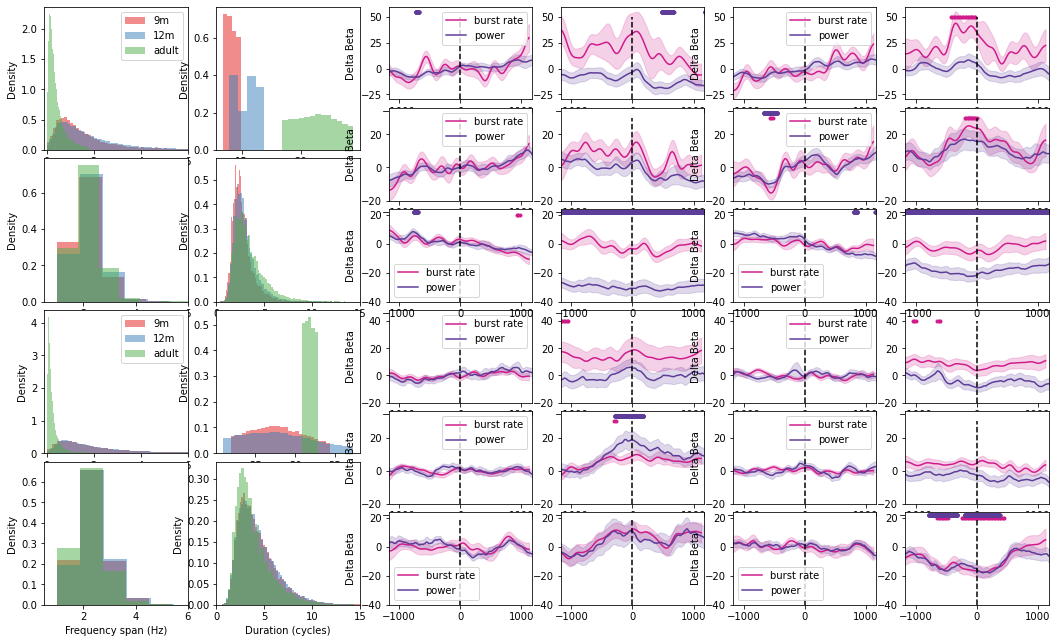

In [126]:
threshold_tfce = dict(start=0, step=0.01)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

buffer=125
bin_dt=25

rate_color=np.array([208,28,139,255])/255.0
power_color=np.array([94,60,153,255])/255.0
nine_color=np.array([228,26,28])/255.0
twelve_color=np.array([55,126,184])/255.0
adult_color=np.array([77,175,74])/255.0

base_times=np.linspace(-1300,1300,1300)
exp_times=np.linspace(-1300,1300,1300)

base_bins=np.arange(base_times[0]+buffer,base_times[-1]-buffer,bin_dt)
exp_bins=np.arange(exp_times[0]+buffer,exp_times[-1]-buffer,bin_dt)

fig=plt.figure(figsize=(18,11), facecolor='w')
gs = fig.add_gridspec(12,6)

ax = fig.add_subplot(gs[0:3, 0])
_=plt.hist(c_bursts_9m['peak_amp_base'],100,alpha=.5,label='9m', density=True, color=nine_color)
_=plt.hist(c_bursts_12m['peak_amp_base'],100,alpha=.5,label='12m', density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['peak_amp_base'],100,alpha=.5,label='adult', density=True, color=adult_color)
ax.set_xlim([-.1,6])
ax.set_xlabel('Peak amplitude (uV)')
ax.set_ylabel('Density')
ax.legend()
ax = fig.add_subplot(gs[0:3, 1])
_=plt.hist(c_bursts_9m['peak_freq'],4,alpha=.5, density=True, color=nine_color)
_=plt.hist(c_bursts_12m['peak_freq'],4,alpha=.5, density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['peak_freq'],13,alpha=.5, density=True, color=adult_color)
ax.set_xlabel('Peak frequency (Hz)')
ax.set_ylabel('Density')
ax = fig.add_subplot(gs[3:6, 0])
_=plt.hist(c_bursts_9m['fwhm_freq'],7,alpha=.5, density=True, color=nine_color)
_=plt.hist(c_bursts_12m['fwhm_freq'],8,alpha=.5, density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['fwhm_freq'],10,alpha=.5, density=True, color=adult_color)
ax.set_xlim([0.5,6])
ax.set_xlabel('Frequency span (Hz)')
ax.set_ylabel('Density')
ax = fig.add_subplot(gs[3:6, 1])
_=plt.hist(c_bursts_9m['fwhm_time']/(1000/c_bursts_9m['peak_freq']),100,alpha=.5, density=True, color=nine_color)
_=plt.hist(c_bursts_12m['fwhm_time']/(1000/c_bursts_12m['peak_freq']),100,alpha=.5, density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['fwhm_time']/(1000/c_bursts_adult['peak_freq']),100,alpha=.5, density=True, color=adult_color)
ax.set_xlim([0,15])
ax.set_xlabel('Duration (cycles)')
ax.set_ylabel('Density')

ax = fig.add_subplot(gs[6:9, 0])
_=plt.hist(p_bursts_9m['peak_amp_base'],100,alpha=.5,label='9m', density=True, color=nine_color)
_=plt.hist(p_bursts_12m['peak_amp_base'],100,alpha=.5,label='12m', density=True, color=twelve_color)
_=plt.hist(p_bursts_adult['peak_amp_base'],100,alpha=.5,label='adult', density=True, color=adult_color)
ax.set_xlim([-.1,6])
ax.set_xlabel('Peak amplitude (uV)')
ax.set_ylabel('Density')
ax.legend()
ax = fig.add_subplot(gs[6:9, 1])
_=plt.hist(p_bursts_9m['peak_freq'],26,alpha=.5, density=True, color=nine_color)
_=plt.hist(p_bursts_12m['peak_freq'],34,alpha=.5, density=True, color=twelve_color)
_=plt.hist(p_bursts_adult['peak_freq'],5,alpha=.5, density=True, color=adult_color)
ax.set_xlabel('Peak frequency (Hz)')
ax.set_ylabel('Density')
ax = fig.add_subplot(gs[9:12, 0])
_=plt.hist(p_bursts_9m['fwhm_freq'],9,alpha=.5, density=True, color=nine_color)
_=plt.hist(p_bursts_12m['fwhm_freq'],10,alpha=.5, density=True, color=twelve_color)
_=plt.hist(p_bursts_adult['fwhm_freq'],9,alpha=.5, density=True, color=adult_color)
ax.set_xlim([0.5,6])
ax.set_xlabel('Frequency span (Hz)')
ax.set_ylabel('Density')
ax = fig.add_subplot(gs[9:12, 1])
_=plt.hist(p_bursts_9m['fwhm_time']/(1000/p_bursts_9m['peak_freq']),100,alpha=.5, density=True, color=nine_color)
_=plt.hist(p_bursts_12m['fwhm_time']/(1000/p_bursts_12m['peak_freq']),100,alpha=.5, density=True, color=twelve_color)
_=plt.hist(p_bursts_adult['fwhm_time']/(1000/p_bursts_adult['peak_freq']),100,alpha=.5, density=True, color=adult_color)
ax.set_xlim([0,15])
ax.set_xlabel('Duration (cycles)')
ax.set_ylabel('Density')


def plot_age_cond(ax1,ax2,base_rate,base_tf,exe_rate,exe_tf, yl):
    ax1.fill_between(base_bins[:-1],
                 np.nanmean(base_rate,axis=0)-np.std(base_rate,axis=0)/np.sqrt(base_rate.shape[0]),
                 np.nanmean(base_rate,axis=0)+np.std(base_rate,axis=0)/np.sqrt(base_rate.shape[0]),
                 color=rate_color, alpha=.2)
    ax1.plot(base_bins[:-1],np.nanmean(base_rate,axis=0),color=rate_color, label='burst rate')
    ax1.fill_between(exe_time_9m,
                     np.nanmean(base_tf,axis=0)-np.std(base_tf,axis=0)/np.sqrt(base_tf.shape[0]),
                     np.nanmean(base_tf,axis=0)+np.std(base_tf,axis=0)/np.sqrt(base_tf.shape[0]),
                     color=power_color, alpha=.2)
    ax1.plot(exe_time_9m,np.nanmean(base_tf,axis=0),color=power_color, label='power')

    ax2.fill_between(exp_bins[:-1],
                     np.nanmean(exe_rate,axis=0)-np.std(exe_rate,axis=0)/np.sqrt(exe_rate.shape[0]),
                     np.nanmean(exe_rate,axis=0)+np.std(exe_rate,axis=0)/np.sqrt(exe_rate.shape[0]),
                     color=rate_color, alpha=.2)
    ax2.plot(exp_bins[:-1],np.nanmean(exe_rate,axis=0),color=rate_color)
    ax2.fill_between(exe_time_9m,
                     np.nanmean(exe_tf,axis=0)-np.std(exe_tf,axis=0)/np.sqrt(exe_tf.shape[0]),
                     np.nanmean(exe_tf,axis=0)+np.std(exe_tf,axis=0)/np.sqrt(exe_tf.shape[0]),
                     color=power_color, alpha=.2)
    ax2.plot(exe_time_9m,np.nanmean(exe_tf,axis=0),color=power_color)

    pos_range=yl[1]

    rate_mb_T_HAT, _, rate_mb_P_HAT, _ = permutation_cluster_1samp_test(
        base_rate, stat_fun = hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )

    rate_me_T_HAT, _, rate_me_P_HAT, _ = permutation_cluster_1samp_test(
        exe_rate, stat_fun = hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )
    
    for i in range(len(base_bins)-1):
        if rate_mb_P_HAT[i]<0.05:
            ax1.plot(base_bins[i],yl[1]+0*.1*pos_range, '.', color=rate_color)

    for i in range(len(exp_bins)-1):
        if rate_me_P_HAT[i]<0.05:
            ax2.plot(exp_bins[i],yl[1]+0*.1*pos_range, '.',color=rate_color)
            

    power_mb_T_HAT, _, power_mb_P_HAT, _ = permutation_cluster_1samp_test(
        base_tf, stat_fun = hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )

    power_me_T_HAT, _, power_me_P_HAT, _ = permutation_cluster_1samp_test(
        exe_tf, stat_fun = hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )
    
    for i in range(len(exe_time_9m)):
        if power_mb_P_HAT[i]<0.05:
            ax1.plot(exe_time_9m[i],yl[1]+1*.1*pos_range, '.', color=power_color)

    for i in range(len(exe_time_9m)):
        if power_me_P_HAT[i]<0.05:
            ax2.plot(exe_time_9m[i],yl[1]+1*.1*pos_range, '.',color=power_color)

    ax1.set_ylabel('Delta Beta')

    ax1.plot([0,0],yl,'k--')
    ax2.plot([0,0],yl,'k--')
    new_yl=[yl[0], yl[1]+2*.1*pos_range]
            
    ax1.set_ylim(new_yl)
    ax2.set_ylim(new_yl)

    ax1.set_xlim([base_times[0]+buffer, base_times[-1]-buffer])
    ax2.set_xlim([exp_times[0]+buffer, exp_times[-1]-buffer])    
    ax1.legend()
    
yl=[-30, 50]
ax1 = fig.add_subplot(gs[0:2, 2])
ax2 = fig.add_subplot(gs[0:2, 3])
plot_age_cond(ax1,ax2,c_exe_base_rate_9m,c_exe_base_tfs_9m,c_exe_exp_rate_9m,c_exe_exp_tfs_9m,yl)

ax1 = fig.add_subplot(gs[0:2, 4])
ax2 = fig.add_subplot(gs[0:2, 5])
plot_age_cond(ax1,ax2,c_obs_base_rate_9m,c_obs_base_tfs_9m,c_obs_exp_rate_9m,c_obs_exp_tfs_9m,yl)

yl=[-20, 40]
ax1 = fig.add_subplot(gs[6:8, 2])
ax2 = fig.add_subplot(gs[6:8, 3])
plot_age_cond(ax1,ax2,p_exe_base_rate_9m,p_exe_base_tfs_9m,p_exe_exp_rate_9m,p_exe_exp_tfs_9m,yl)

ax1 = fig.add_subplot(gs[6:8, 4])
ax2 = fig.add_subplot(gs[6:8, 5])
plot_age_cond(ax1,ax2,p_obs_base_rate_9m,p_obs_base_tfs_9m,p_obs_exp_rate_9m,p_obs_exp_tfs_9m,yl)


yl=[-20, 30]
ax1 = fig.add_subplot(gs[2:4, 2])
ax2 = fig.add_subplot(gs[2:4, 3])
plot_age_cond(ax1,ax2,c_exe_base_rate_12m,c_exe_base_tfs_12m,c_exe_exp_rate_12m,c_exe_exp_tfs_12m,yl)
    
ax1 = fig.add_subplot(gs[2:4, 4])
ax2 = fig.add_subplot(gs[2:4, 5])
plot_age_cond(ax1,ax2,c_obs_base_rate_12m,c_obs_base_tfs_12m,c_obs_exp_rate_12m,c_obs_exp_tfs_12m,yl)

yl=[-20, 30]
ax1 = fig.add_subplot(gs[8:10, 2])
ax2 = fig.add_subplot(gs[8:10, 3])
plot_age_cond(ax1,ax2,p_exe_base_rate_12m,p_exe_base_tfs_12m,p_exe_exp_rate_12m,p_exe_exp_tfs_12m,yl)
    
ax1 = fig.add_subplot(gs[8:10, 4])
ax2 = fig.add_subplot(gs[8:10, 5])
plot_age_cond(ax1,ax2,p_obs_base_rate_12m,p_obs_base_tfs_12m,p_obs_exp_rate_12m,p_obs_exp_tfs_12m,yl)


yl=[-40, 20]
ax1 = fig.add_subplot(gs[4:6, 2])
ax2 = fig.add_subplot(gs[4:6, 3])
plot_age_cond(ax1,ax2,c_exe_base_rate_adult,c_exe_base_tfs_adult,c_exe_exp_rate_adult,c_exe_exp_tfs_adult,yl)
    
ax1 = fig.add_subplot(gs[4:6, 4])
ax2 = fig.add_subplot(gs[4:6, 5])
plot_age_cond(ax1,ax2,c_obs_base_rate_adult,c_obs_base_tfs_adult,c_obs_exp_rate_adult,c_obs_exp_tfs_adult,yl)

ax1 = fig.add_subplot(gs[10:12, 2])
ax2 = fig.add_subplot(gs[10:12, 3])
plot_age_cond(ax1,ax2,p_exe_base_rate_adult,p_exe_base_tfs_adult,p_exe_exp_rate_adult,p_exe_exp_tfs_adult,yl)
    
ax1 = fig.add_subplot(gs[10:12, 4])
ax2 = fig.add_subplot(gs[10:12, 5])
plot_age_cond(ax1,ax2,p_obs_base_rate_adult,p_obs_base_tfs_adult,p_obs_exp_rate_adult,p_obs_exp_tfs_adult,yl)


fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure3.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure3.png')